Estimate a DWI signal using the eddymotion Gaussian Process (GP) regressor estimator.

Download the "Sherbrooke 3-shell" dataset using DIPY and select the b=1000 s/mm^2 shell data.

In [1]:
import dipy.data as dpd
import nibabel as nib
import numpy as np
from dipy.core.gradients import get_bval_indices
from dipy.io import read_bvals_bvecs
from dipy.segment.mask import median_otsu

seed = 1234
rng = np.random.default_rng(seed)

name = "sherbrooke_3shell"

dwi_fname, bval_fname, bvec_fname = dpd.get_fnames(name=name)
dwi_data = nib.load(dwi_fname).get_fdata()
bvals, bvecs = read_bvals_bvecs(bval_fname, bvec_fname)

_, brain_mask = median_otsu(dwi_data, vol_idx=[0])

bval = 1000
indices = get_bval_indices(bvals, bval, tol=20)

bvecs_shell = bvecs[indices]
shell_data = dwi_data[..., indices]

Visualize a slice of the data for a given DWI volume.

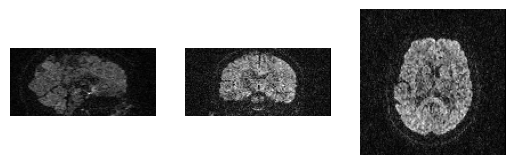

In [2]:
# Plot a slice
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

dwi_vol_idx = len(indices) // 2
slice_idx = list(map(int, np.divide(dwi_data.shape[:-1], 2)))

x_slice = dwi_data[slice_idx[0], :, :, dwi_vol_idx]
y_slice = dwi_data[:, slice_idx[1], :, dwi_vol_idx]
z_slice = dwi_data[:, :, slice_idx[2], dwi_vol_idx]
slices = [x_slice, y_slice, z_slice]

fig, axes = plt.subplots(1, len(slices))
for i, _slice in enumerate(slices):
    axes[i].imshow(_slice.T, cmap="gray", origin="lower", aspect='equal')
    axes[i].set_axis_off()

plt.show()

Define the EddyMotionGPR instance.

In [3]:
from eddymotion.model.gpr import EddyMotionGPR, SphericalKriging

beta_a = 1.38
beta_l = 1 / 2.1
kernel = SphericalKriging(beta_a=beta_a, beta_l=beta_l)

alpha = 0.1
disp = True
optimizer = None
gpr = EddyMotionGPR(kernel=kernel, alpha=alpha, disp=disp, optimizer=optimizer)


Do not optimize the parameters in the fitting. 

In [4]:
X_train = bvecs_shell
# Consider only brain voxels
dwi_mask = np.repeat(brain_mask[..., np.newaxis], shell_data.shape[-1], axis=-1)
y_train = shell_data[dwi_mask].reshape((X_train.shape[0], -1))
gpr.fit(X_train, y_train)

EddyMotionGPR(alpha=0.1, disp=True,
              kernel=SphericalKriging (a=1.38, λ=0.47619047619047616),
              optimizer=None)

Predict on a randomly picked diffusion-encoding gradient direction.

In [5]:
# Pick a direction to predict
idx = rng.integers(0, len(indices))
X_test = bvecs_shell[idx][np.newaxis, :]
y_pred = gpr.predict(X_test)

rmse = np.sqrt(np.mean(np.square(y_train[idx, ...] - y_pred.squeeze())))
_rmse_element = np.sqrt(np.square(y_train[idx, ...] - y_pred.squeeze()))

print(f"RMSE: {rmse}")
threshold = 10
n_error_thr = len(_rmse_element[_rmse_element > threshold])
ratio = n_error_thr / len(_rmse_element) * 100
print(f"Number of RMSE values above {threshold}: {n_error_thr} ({ratio:.2f}%)")

RMSE: 20.177777097314834
Number of RMSE values above 10: 97093 (61.20%)


Visualize the prediction.

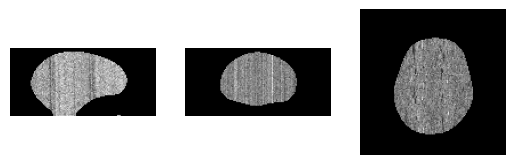

In [6]:
# Reshape the predicted data array to the image shape
brain_mask_idx = np.where(brain_mask)
_y_pred = np.zeros((shell_data.shape[:-1]), dtype=y_train.dtype)
_y_pred[brain_mask_idx] = y_pred.squeeze()

x_slice = _y_pred[slice_idx[0], :, :]
y_slice = _y_pred[:, slice_idx[1], :]
z_slice = _y_pred[:, :, slice_idx[2]]
slices = [x_slice, y_slice, z_slice]

fig, axes = plt.subplots(1, len(slices))
for i, _slice in enumerate(slices):
     axes[i].imshow(_slice.T, cmap="gray", origin="lower", aspect='equal')
     axes[i].set_axis_off()

plt.show()

Select a number of brain voxels at random to perform the GP parameter optimization. The same voxels will be selected across each DWI volume.

In [7]:
n_voxels = 10000
true_indices = np.argwhere(brain_mask)

# Sample indices randomly
num_samples = min(n_voxels, len(true_indices))
sampled_indices = true_indices[np.random.choice(len(true_indices), num_samples, replace=False)]

sampled_dwi = shell_data[sampled_indices[:, 0], sampled_indices[:, 1], sampled_indices[:, 2], :].T

Use a k-fold cross-validation and a grid search to find the best parameters.

In [8]:
from sklearn.model_selection import GridSearchCV, KFold

# Define the hyperparameter grid
param_grid = {
    "kernel__beta_a": np.linspace(np.pi/4, np.pi/2, 2),
    "kernel__beta_l": np.linspace(0.1, 1 / 2.1, 2),
    "alpha": np.linspace(1e-3, 1e-2, 2)
}

optimizer = "fmin_l_bfgs_b"
gpr = EddyMotionGPR(kernel=kernel, alpha=alpha, disp=disp, optimizer=optimizer)

# Define k-fold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=seed)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=gpr, param_grid=param_grid, cv=cv, scoring="neg_mean_squared_error")
grid_search.fit(X_train, sampled_dwi)

print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {-grid_search.best_score_}")

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.00084D+06    |proj g|=  9.21034D+00

At iterate    1    f=  2.23039D+06    |proj g|=  1.38155D+01

At iterate    2    f=  7.23889D+05    |proj g|=  6.95102D+00

At iterate    3    f=  7.23693D+05    |proj g|=  6.92318D+00

At iterate    4    f=  7.23659D+05    |proj g|=  6.90777D+00

At iterate    5    f=  7.23659D+05    |proj g|=  6.47262D+00

At iterate    6    f=  7.23659D+05    |proj g|=  9.89565D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/home/jhlegarreta/.virtualenvs/eddymotion/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter beta_a is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.93671D+06    |proj g|=  9.21034D+00

At iterate    1    f=  2.23039D+06    |proj g|=  1.38155D+01

At iterate    2    f=  7.23926D+05    |proj g|=  6.95426D+00

At iterate    3    f=  7.23700D+05    |proj g|=  6.92476D+00

At iterate    4    f=  7.23659D+05    |proj g|=  6.90796D+00

At iterate    5    f=  7.23659D+05    |proj g|=  6.90879D+00


/home/jhlegarreta/.virtualenvs/eddymotion/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter beta_a is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(



At iterate    6    f=  7.23659D+05    |proj g|=  1.50953D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     22      7     0     1   1.510D-02   7.237D+05
  F =   723658.65193438367     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.92653D+06    |proj g|=  9.21034D+00

At iterate    1    f=  2.23039D+06    |proj g|=  1.38155D+01

At iterate    2    f=  7.23948D+05    |proj g|=  6.95605D+00

At iter

/home/jhlegarreta/.virtualenvs/eddymotion/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter beta_a is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(



At iterate    6    f=  7.23659D+05    |proj g|=  1.88219D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     22      7     0     1   1.882D-02   7.237D+05
  F =   723658.65193438367     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.94029D+06    |proj g|=  9.21034D+00

At iterate    1    f=  2.23039D+06    |proj g|=  1.38155D+01

At iterate    2    f=  7.23917D+05    |proj g|=  6.95348D+00

At iter

/home/jhlegarreta/.virtualenvs/eddymotion/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter beta_a is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(



At iterate    6    f=  7.23659D+05    |proj g|=  1.36717D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     22      7     0     1   1.367D-02   7.237D+05
  F =   723658.65193438344     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.00075D+06    |proj g|=  9.21034D+00

At iterate    1    f=  2.27412D+06    |proj g|=  1.38155D+01

At iterate    2    f=  7.38150D+05    |proj g|=  6.95660D+00

At iter

/home/jhlegarreta/.virtualenvs/eddymotion/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter beta_a is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(



At iterate    6    f=  7.37848D+05    |proj g|=  2.05235D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     22      7     0     1   2.052D-02   7.378D+05
  F =   737848.03726643079     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08723D+06    |proj g|=  7.64969D+00

At iterate    1    f=  8.83932D+05    |proj g|=  8.32144D+00

At iterate    2    f=  7.76269D+05    |proj g|=  7.82081D+00

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    6    f=  7.65625D+05    |proj g|=  7.62520D+00

At iterate    7    f=  7.54900D+05    |proj g|=  6.54833D+00

At iterate    8    f=  7.54427D+05    |proj g|=  6.69883D+00

At iterate    9    f=  7.54314D+05    |proj g|=  6.74652D+00

At iterate   10    f=  7.53938D+05    |proj g|=  6.86533D+00

At iterate   11    f=  7.53839D+05    |proj g|=  6.97181D+00

At iterate   12    f=  7.53682D+05    |proj g|=  7.03698D+00

At iterate   13    f=  7.53640D+05    |proj g|=  7.19362D+00

At iterate   14    f=  7.52778D+05    |proj g|=  7.31218D+00

At iterate   15    f=  7.40147D+05    |proj g|=  7.25559D+00

At iterate   16    f=  7.20996D+05    |proj g|=  7.03999D+00

At iterate   17    f=  7.18577D+05    |proj g|=  6.96253D+00

At iterate   18    f=  7.18126D+05    |proj g|=  6.91793D+00

At iterate   19    f=  7.18110D+05    |proj g|=  6.90834D+00

At iterate   20    f=  7.18110D+05    |proj g|=  6.90740D+00

At iterate   21    f=  7.18110D+05    |proj g|=  3.62404D+00

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    5    f=  7.62885D+05    |proj g|=  6.65611D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5     30      6     0     0   6.656D+00   7.629D+05
  F =   762884.93959453050     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07316D+06    |proj g|=  7.64969D+00

At iterate    1    f=  8.82422D+05    |proj g|=  8.31001D+00

At iterate    2    f=  7.71894D+05    |proj g|=  7.75235D+00

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    7    f=  7.25311D+05    |proj g|=  7.04881D+00

At iterate    8    f=  7.20388D+05    |proj g|=  6.97588D+00

At iterate    9    f=  7.18070D+05    |proj g|=  6.99080D+00

At iterate   10    f=  7.17117D+05    |proj g|=  6.91651D+00

At iterate   11    f=  7.17103D+05    |proj g|=  6.90916D+00

At iterate   12    f=  7.17103D+05    |proj g|=  6.90864D+00

At iterate   13    f=  7.17103D+05    |proj g|=  6.90856D+00

At iterate   14    f=  7.17103D+05    |proj g|=  1.67323D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     14     50     17     1     0   1.673D+00   7.171D+05
  F =   717102.791390


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    8    f=  7.62784D+05    |proj g|=  7.59947D+00

At iterate    9    f=  7.46995D+05    |proj g|=  6.68758D+00

At iterate   10    f=  7.46722D+05    |proj g|=  6.73618D+00

At iterate   11    f=  7.46606D+05    |proj g|=  6.98182D+00

At iterate   12    f=  7.46408D+05    |proj g|=  7.09454D+00

At iterate   13    f=  7.45521D+05    |proj g|=  7.30952D+00

At iterate   14    f=  7.27416D+05    |proj g|=  7.14360D+00

At iterate   15    f=  7.19297D+05    |proj g|=  7.02035D+00

At iterate   16    f=  7.17592D+05    |proj g|=  6.94187D+00

At iterate   17    f=  7.17439D+05    |proj g|=  6.91330D+00

At iterate   18    f=  7.17435D+05    |proj g|=  6.90797D+00

At iterate   19    f=  7.17435D+05    |proj g|=  6.90808D+00

At iterate   20    f=  7.17435D+05    |proj g|=  6.90810D+00

At iterate   21    f=  7.17435D+05    |proj g|=  4.47102D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    7    f=  7.38452D+05    |proj g|=  7.03452D+00

At iterate    8    f=  7.33912D+05    |proj g|=  6.96037D+00

At iterate    9    f=  7.31901D+05    |proj g|=  6.97224D+00

At iterate   10    f=  7.31319D+05    |proj g|=  6.91288D+00

At iterate   11    f=  7.31313D+05    |proj g|=  6.90865D+00

At iterate   12    f=  7.31312D+05    |proj g|=  6.90821D+00

At iterate   13    f=  7.31312D+05    |proj g|=  6.90820D+00

At iterate   14    f=  7.31312D+05    |proj g|=  1.67795D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     14     50     17     1     0   1.678D+00   7.313D+05
  F =   731312.481900

/home/jhlegarreta/.virtualenvs/eddymotion/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter beta_a is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(



At iterate    6    f=  7.23659D+05    |proj g|=  2.05783D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     23      7     0     1   2.058D-02   7.237D+05
  F =   723658.65193438367     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.74503D+06    |proj g|=  9.21034D+00

At iterate    1    f=  2.23039D+06    |proj g|=  1.38155D+01

At iterate    2    f=  7.24458D+05    |proj g|=  6.98701D+00

At iter

/home/jhlegarreta/.virtualenvs/eddymotion/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter beta_a is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(



At iterate    7    f=  7.23659D+05    |proj g|=  1.18141D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     24      8     0     1   1.181D-04   7.237D+05
  F =   723658.65193438309     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.70901D+06    |proj g|=  9.21034D+00

At iterate    1    f=  2.23039D+06    |proj g|=  1.38155D+01

At iterate    2    f=  7.24805D+05    |proj g|=  7.00221D+00

At iter

/home/jhlegarreta/.virtualenvs/eddymotion/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter beta_a is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(



At iterate    7    f=  7.23659D+05    |proj g|=  6.50553D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     24      8     0     1   6.506D-04   7.237D+05
  F =   723658.65193438309     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.73957D+06    |proj g|=  9.21034D+00

At iterate    1    f=  2.23039D+06    |proj g|=  1.38155D+01

At iterate    2    f=  7.24552D+05    |proj g|=  6.99141D+00

At iter

/home/jhlegarreta/.virtualenvs/eddymotion/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter beta_a is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(



At iterate    7    f=  7.23659D+05    |proj g|=  1.99262D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     24      8     0     1   1.993D-04   7.237D+05
  F =   723658.65193438309     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.86753D+06    |proj g|=  9.21034D+00

At iterate    1    f=  2.27412D+06    |proj g|=  1.38155D+01

At iterate    2    f=  7.38926D+05    |proj g|=  6.99855D+00

At iter

/home/jhlegarreta/.virtualenvs/eddymotion/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter beta_a is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(



At iterate    7    f=  7.37848D+05    |proj g|=  4.50810D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     24      8     0     1   4.508D-04   7.378D+05
  F =   737848.03726642986     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.81537D+06    |proj g|=  7.64969D+00

At iterate    1    f=  9.15845D+05    |proj g|=  8.64108D+00

At iterate    2    f=  8.11262D+05    |proj g|=  8.52536D+00

At iter

/home/jhlegarreta/.virtualenvs/eddymotion/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter beta_a is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(



At iterate    7    f=  7.23659D+05    |proj g|=  7.24672D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     23      8     0     1   7.247D-05   7.237D+05
  F =   723658.65193438309     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.21021D+06    |proj g|=  9.21034D+00

At iterate    1    f=  2.23039D+06    |proj g|=  1.38155D+01

At iterate    2    f=  7.24785D+05    |proj g|=  7.01132D+00

At iter

/home/jhlegarreta/.virtualenvs/eddymotion/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter beta_a is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(



At iterate    7    f=  7.23659D+05    |proj g|=  5.26542D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     23      8     0     1   5.265D-04   7.237D+05
  F =   723658.65193438309     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.19964D+06    |proj g|=  9.21034D+00

At iterate    1    f=  2.23039D+06    |proj g|=  1.38155D+01

At iterate    2    f=  7.25031D+05    |proj g|=  7.02087D+00

At iter

/home/jhlegarreta/.virtualenvs/eddymotion/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter beta_a is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(



At iterate    7    f=  7.23659D+05    |proj g|=  1.35821D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     23      8     0     1   1.358D-03   7.237D+05
  F =   723658.65193438309     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.20595D+06    |proj g|=  9.21034D+00

At iterate    1    f=  2.23039D+06    |proj g|=  1.38155D+01

At iterate    2    f=  7.24935D+05    |proj g|=  7.01728D+00

At iter

/home/jhlegarreta/.virtualenvs/eddymotion/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter beta_a is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(



At iterate    7    f=  7.23659D+05    |proj g|=  9.59853D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     23      8     0     1   9.599D-04   7.237D+05
  F =   723658.65193438309     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26019D+06    |proj g|=  9.21034D+00

At iterate    1    f=  2.27413D+06    |proj g|=  1.38155D+01

At iterate    2    f=  7.37904D+05    |proj g|=  6.93865D+00

At iter

/home/jhlegarreta/.virtualenvs/eddymotion/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter beta_a is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(



At iterate    6    f=  7.37848D+05    |proj g|=  1.56000D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     21      7     0     1   1.560D-04   7.378D+05
  F =   737848.03726642986     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05212D+06    |proj g|=  7.64969D+00

At iterate    1    f=  8.73327D+05    |proj g|=  8.26664D+00

At iterate    2    f=  8.00507D+05    |proj g|=  7.95926D+00

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  7.54887D+05    |proj g|=  7.52081D+00

At iterate    6    f=  7.37759D+05    |proj g|=  7.25689D+00

At iterate    7    f=  7.32275D+05    |proj g|=  6.99577D+00

At iterate    8    f=  7.26958D+05    |proj g|=  6.98589D+00

At iterate    9    f=  7.20211D+05    |proj g|=  7.04582D+00

At iterate   10    f=  7.18098D+05    |proj g|=  6.92617D+00

At iterate   11    f=  7.18086D+05    |proj g|=  6.91764D+00

At iterate   12    f=  7.18085D+05    |proj g|=  6.89946D+00

At iterate   13    f=  7.18085D+05    |proj g|=  6.89922D+00

At iterate   14    f=  7.18085D+05    |proj g|=  2.25798D+00

At iterate   15    f=  7.18085D+05    |proj g|=  9.33477D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

/home/jhlegarreta/.virtualenvs/eddymotion/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter beta_a is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(



At iterate    6    f=  7.23659D+05    |proj g|=  2.05885D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     22      7     0     1   2.059D-02   7.237D+05
  F =   723658.65193438367     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.39364D+06    |proj g|=  9.21034D+00

At iterate    1    f=  2.23039D+06    |proj g|=  1.38155D+01

At iterate    2    f=  7.23966D+05    |proj g|=  6.96699D+00

At iter

/home/jhlegarreta/.virtualenvs/eddymotion/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter beta_a is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(



At iterate    6    f=  7.23659D+05    |proj g|=  2.05985D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     22      7     0     1   2.060D-02   7.237D+05
  F =   723658.65193438367     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.36936D+06    |proj g|=  9.21034D+00

At iterate    1    f=  2.23039D+06    |proj g|=  1.38155D+01

At iterate    2    f=  7.23968D+05    |proj g|=  6.96715D+00

At iter

/home/jhlegarreta/.virtualenvs/eddymotion/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter beta_a is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(



At iterate    6    f=  7.23659D+05    |proj g|=  2.09840D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     22      7     0     1   2.098D-02   7.237D+05
  F =   723658.65193438367     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.37698D+06    |proj g|=  9.21034D+00

At iterate    1    f=  2.23039D+06    |proj g|=  1.38155D+01

At iterate    2    f=  7.23971D+05    |proj g|=  6.96739D+00

At iter

/home/jhlegarreta/.virtualenvs/eddymotion/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter beta_a is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(



At iterate    6    f=  7.23659D+05    |proj g|=  2.15845D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     22      7     0     1   2.158D-02   7.237D+05
  F =   723658.65193438367     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.47557D+06    |proj g|=  9.21034D+00

At iterate    1    f=  2.27413D+06    |proj g|=  1.38155D+01

At iterate    2    f=  7.38164D+05    |proj g|=  6.96722D+00

At iter

/home/jhlegarreta/.virtualenvs/eddymotion/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter beta_a is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(



At iterate    6    f=  7.37848D+05    |proj g|=  2.15751D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     22      7     0     1   2.158D-02   7.378D+05
  F =   737848.03726643079     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.67246D+06    |proj g|=  7.64969D+00

At iterate    1    f=  9.05370D+05    |proj g|=  8.59454D+00

At iterate    2    f=  7.93673D+05    |proj g|=  8.45570D+00

At iter

Train the GP leaving out a randomly picked diffusion-encoding gradient direction and predict on it using the optimized parameters

Define the GP instances with the optimized hiperparameters

In [9]:
kernel = SphericalKriging(beta_a=grid_search.best_params_["kernel__beta_a"], beta_l=grid_search.best_params_["kernel__beta_l"])
gpr = EddyMotionGPR(kernel=kernel, alpha=grid_search.best_params_["alpha"], disp=disp, optimizer=optimizer)

Pick a random diffusion-encoding gradient direction and call fit/predict

In [10]:
idx = rng.integers(0, len(indices))
idx_mask = np.zeros(len(indices), dtype=bool)
idx_mask[idx] = True

X_train = bvecs_shell[~idx_mask]
_dwi_mask = np.repeat(brain_mask[..., np.newaxis], X_train.shape[0], axis=-1)
y_train = shell_data[..., ~idx_mask][_dwi_mask].reshape((X_train.shape[0], -1))

gpr_fit = gpr.fit(X_train, y_train)

X_test = bvecs_shell[idx_mask]
y_pred = gpr_fit.predict(X_test)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.51647D+07    |proj g|=  7.64969D+00

At iterate    1    f=  1.78650D+07    |proj g|=  8.43930D+00

At iterate    2    f=  1.61450D+07    |proj g|=  7.97417D+00

At iterate    3    f=  1.56409D+07    |proj g|=  7.61023D+00

At iterate    4    f=  1.53457D+07    |proj g|=  7.20265D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  1.44974D+07    |proj g|=  6.81551D+00

At iterate    6    f=  1.43453D+07    |proj g|=  6.87952D+00

At iterate    7    f=  1.42177D+07    |proj g|=  7.00259D+00

At iterate    8    f=  1.41897D+07    |proj g|=  6.94118D+00

At iterate    9    f=  1.41844D+07    |proj g|=  6.92042D+00

At iterate   10    f=  1.41830D+07    |proj g|=  6.89929D+00

At iterate   11    f=  1.41824D+07    |proj g|=  6.89793D+00

At iterate   12    f=  1.41820D+07    |proj g|=  6.89811D+00

At iterate   13    f=  1.41818D+07    |proj g|=  6.91827D+00

At iterate   14    f=  1.41818D+07    |proj g|=  6.89926D+00

At iterate   15    f=  1.41818D+07    |proj g|=  6.91796D+00

At iterate   16    f=  1.41818D+07    |proj g|=  1.70266D+00

At iterate   17    f=  1.41818D+07    |proj g|=  3.99657D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

Plot the data.

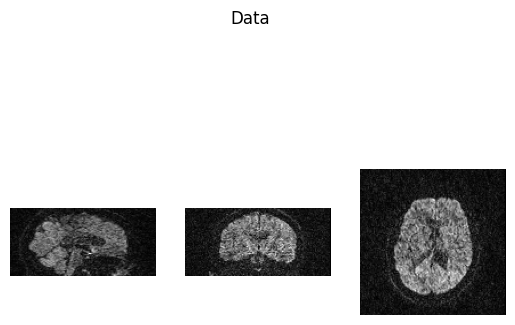

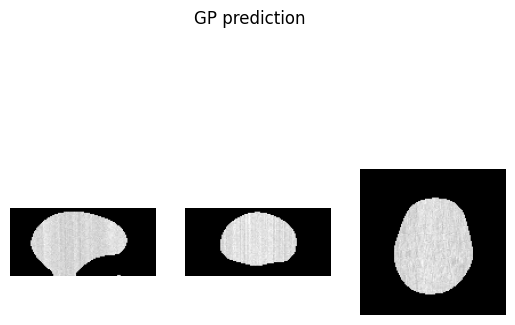

In [11]:
x_slice = shell_data[..., idx][slice_idx[0], :, :]
y_slice = shell_data[..., idx][:, slice_idx[1], :]
z_slice = shell_data[..., idx][:, :, slice_idx[2]]
slices = [x_slice, y_slice, z_slice]

fig, axes = plt.subplots(1, len(slices))
for i, _slice in enumerate(slices):
     axes[i].imshow(_slice.T, cmap="gray", origin="lower", aspect="equal")
     axes[i].set_axis_off()

plt.suptitle("Data")
plt.show()

# Reshape the predicted data array to the image shape
brain_mask_idx = np.where(brain_mask)
_y_pred = np.zeros((shell_data.shape[:-1]), dtype=y_train.dtype)
_y_pred[brain_mask_idx] = y_pred.squeeze()

x_slice = _y_pred[slice_idx[0], :, :]
y_slice = _y_pred[:, slice_idx[1], :]
z_slice = _y_pred[:, :, slice_idx[2]]
slices = [x_slice, y_slice, z_slice]

fig, axes = plt.subplots(1, len(slices))
for i, _slice in enumerate(slices):
     axes[i].imshow(_slice.T, cmap="gray", origin="lower", aspect="equal")
     axes[i].set_axis_off()

plt.suptitle("GP prediction")
plt.show()

Compute the RMSE and plot it

RMSE: 20.108829839123334
Number of RMSE values above 10: 133201 (13.549906412760418%)


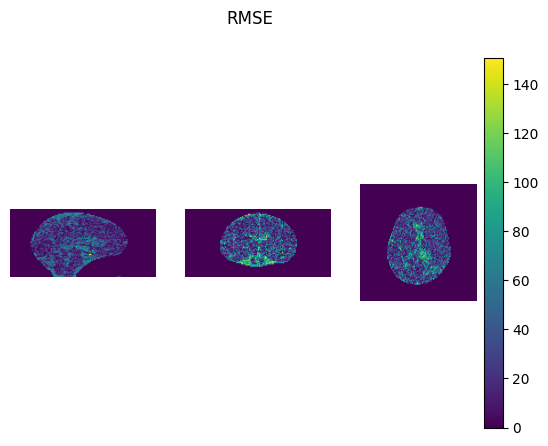

In [12]:
# Multiply the data by the brain mask to remove spurious values that were not predicted
rmse = np.sqrt(np.mean(np.square(shell_data[..., idx]*brain_mask - _y_pred)))
_rmse_element = np.sqrt(np.square(shell_data[..., idx]*brain_mask - _y_pred))

print(f"RMSE: {rmse}")
threshold = 10
n_error_thr = len(_rmse_element[_rmse_element > threshold])
ratio = n_error_thr / np.prod(_rmse_element.shape) * 100
print(f"Number of RMSE values above {threshold}: {n_error_thr} ({ratio}%)")

# Plot the RSME
x_slice = _rmse_element[slice_idx[0], :, :]
y_slice = _rmse_element[:, slice_idx[1], :]
z_slice = _rmse_element[:, :, slice_idx[2]]
slices = [x_slice, y_slice, z_slice]

fig, axes = plt.subplots(1, len(slices))
images = []
for i, _slice in enumerate(slices):
     images.append(axes[i].imshow(_slice.T, cmap="viridis", origin="lower", aspect="equal"))
     axes[i].set_axis_off()

plt.colorbar(images[-1])
plt.suptitle("RMSE")
plt.show()